In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.ticker import AutoMinorLocator
from matplotlib import pyplot as plt, ticker as mticker
import folium

In [2]:
# font sizes
titleSize = 30
axisLabelSize = 24
tickLabelSize = 14
legendTextSize = 14

# colours
backgroundColor = '#292929'
legendColor = 'w'

# misc
standardCanvasHeight = 8
standardCanvasWidth = 16
DPI = 300 #Dots per inch of plots 
cwd = os.getcwd()

In [3]:
summits = pd.read_csv(f'{cwd}/pinnaclePoints.txt', sep=",")

summits['country'] = summits.apply(
    lambda summit: 'Antarctica' if pd.isna(summit.country) and summit.latitude < -60 else summit.country, axis=1)
summits['country'] = summits.apply(
    lambda summit: 'Uncategorized Islands' if pd.isna(summit.country) else summit.country, axis=1)
summits['state'] = summits.apply(
    lambda summit: 'None/Unknown' if pd.isna(summit.state) else summit.state, axis=1)

summits30 = summits.query('prominence_m < 300')
numSummits = len(summits30)
print(f'Number of Points (> 30 m and < 300 m): {numSummits}')
summits300 = summits.query('prominence_m >= 300 and prominence_m < 3000')
numSummits300 = len(summits300)
print(f'Number of Points (> 300 m and < 3000 m): {numSummits300} ({round(numSummits300/numSummits, 2)} of points)')
summits3000 = summits.query('prominence_m >= 3000')
numSummits3000 = len(summits3000)
print(f'Number of Points (> 3000 m): {numSummits3000} ({round(numSummits3000/numSummits, 3)} of points)')

Number of Points (> 30 m and < 300 m): 2170
Number of Points (> 300 m and < 3000 m): 559 (0.26 of points)
Number of Points (> 3000 m): 50 (0.023 of points)


In [4]:
def groupSummitsBy(groupBy, sortBy='number'):
    summitsBy = summits.groupby(groupBy)
    summitsGroupedByCountry = pd.DataFrame()
    summitsGroupedByCountry['country'] = summitsBy.country.agg(pd.Series.mode)
    summitsGroupedByCountry['number'] = summitsBy[groupBy].count()
    summitsGroupedByCountry['totalProminence_m'] = summitsBy.prominence_m.sum()
    summitsGroupedByCountry = summitsGroupedByCountry.sort_values(sortBy, ascending=False)

    return summitsGroupedByCountry

summitsByCountry = groupSummitsBy('country')
summitsByState = groupSummitsBy('state')

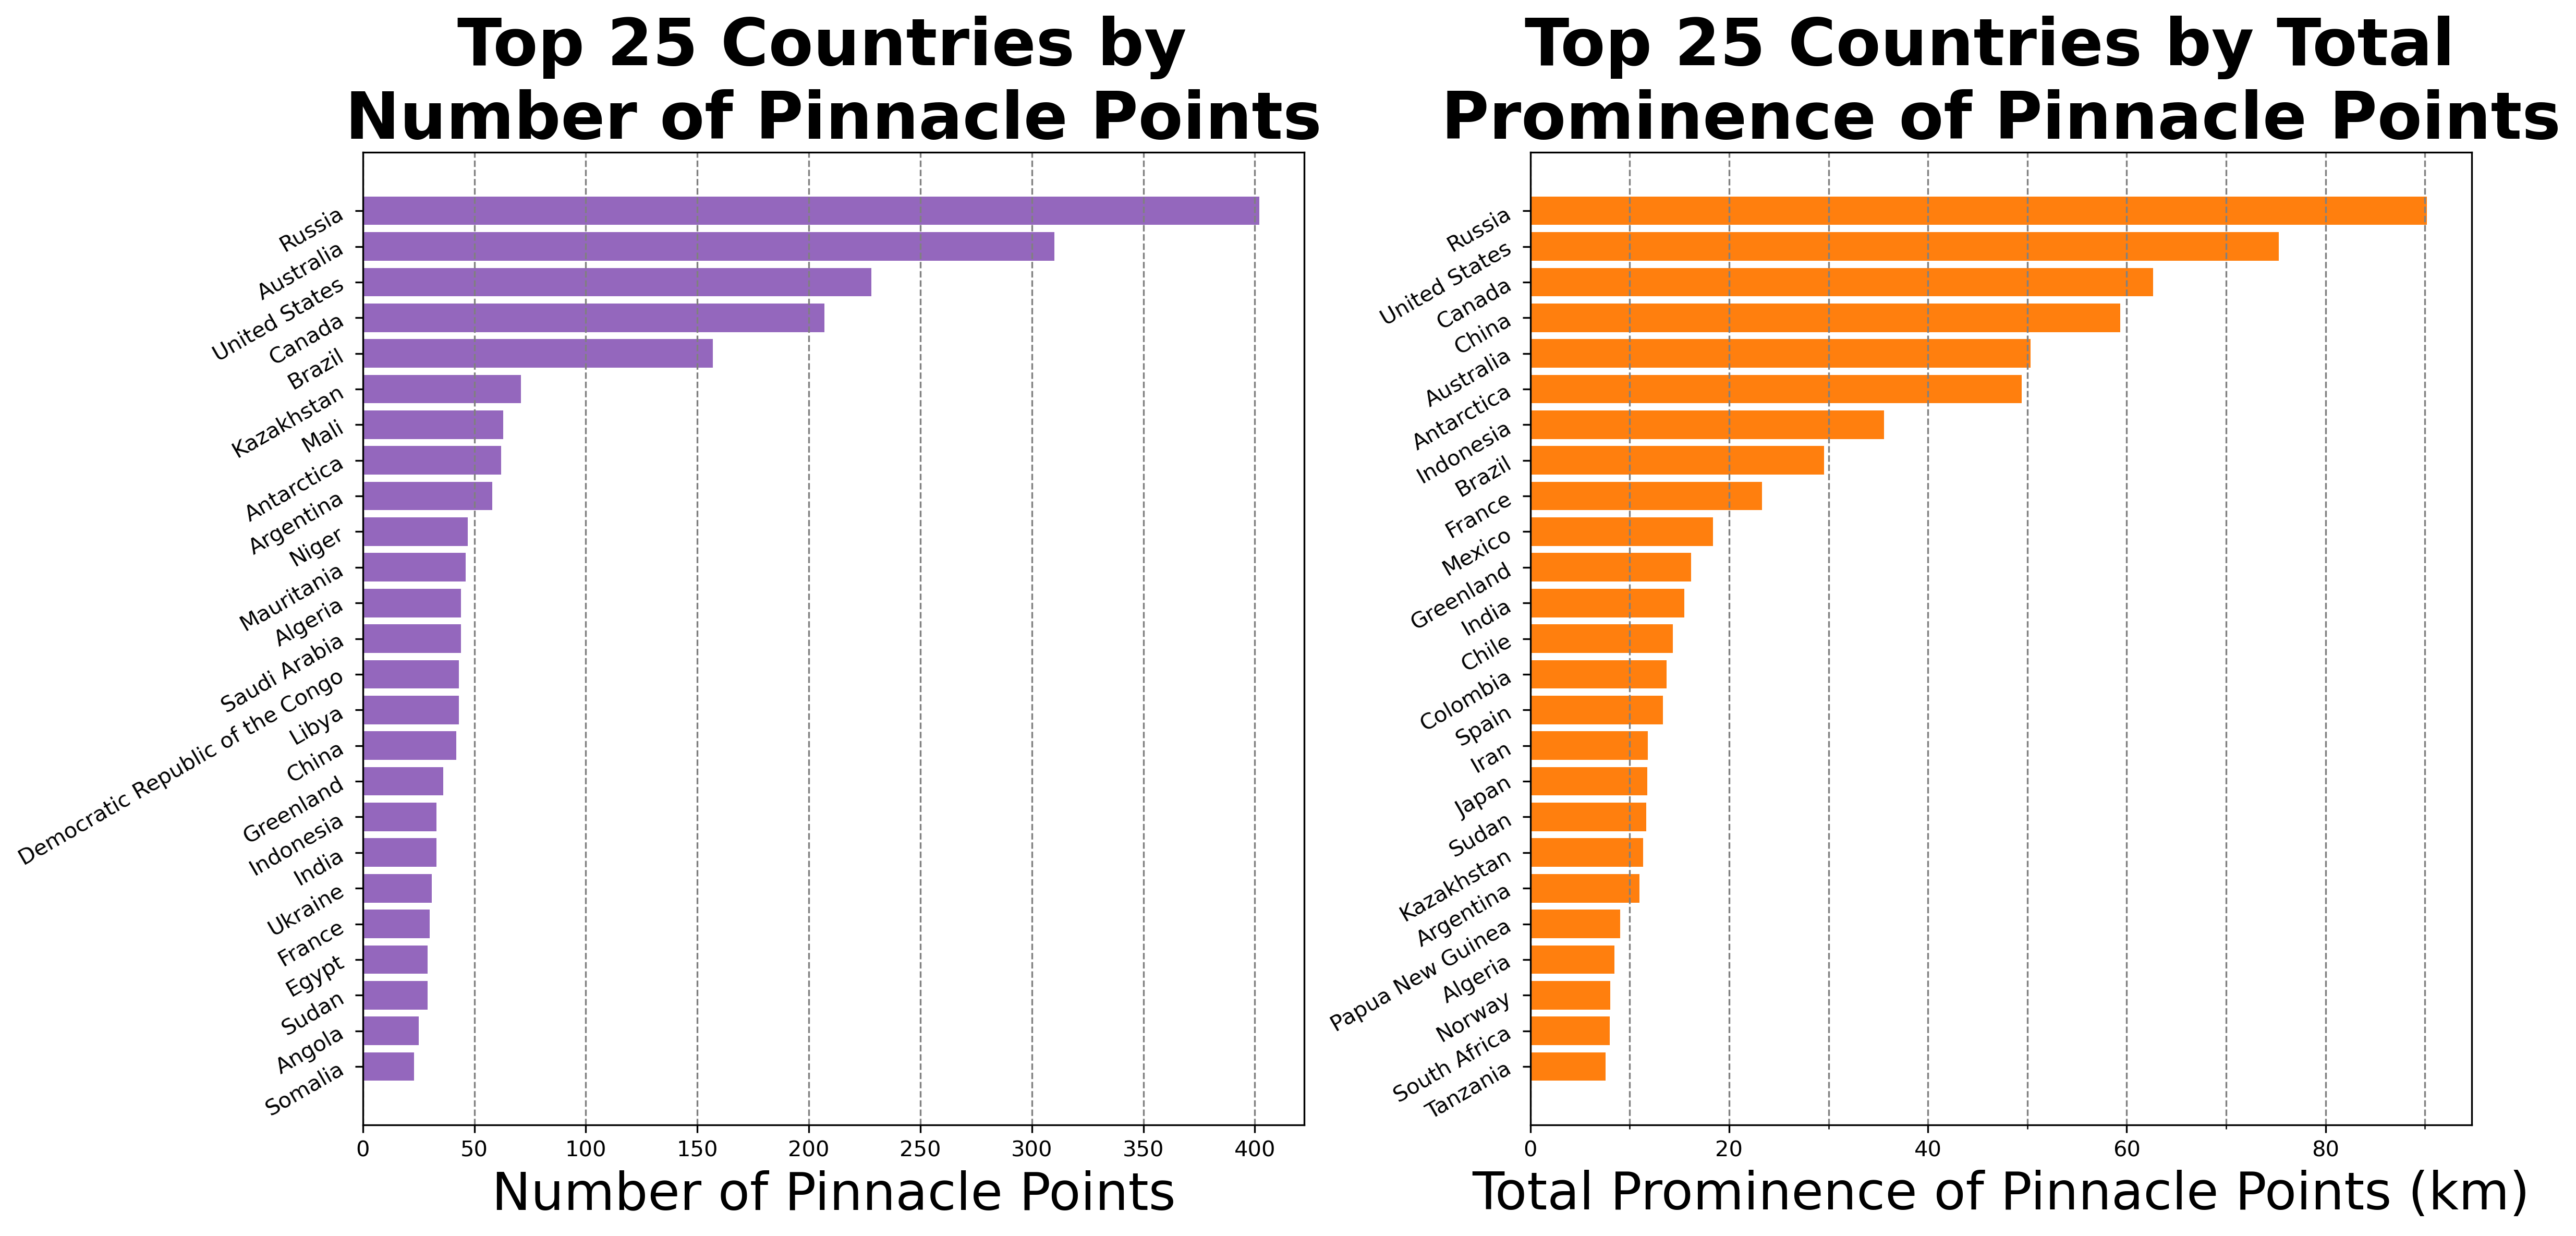

In [5]:
def compareTopGroups(summits, title1, title2, saveFile, num=25):
    
    topSummitsByNumber = summits.sort_values('number', ascending=False).head(num)[::-1]
    topSummitsByTotPrm = summits.sort_values('totalProminence_m', ascending=False).head(num)[::-1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.set_title(title1, size=titleSize, fontweight='bold')
    ax1.barh(topSummitsByNumber.index, topSummitsByNumber.number, color='tab:purple')
    ax1.yaxis.set_major_locator(mticker.FixedLocator(range(len(topSummitsByNumber))))
    ax1.set_yticklabels(topSummitsByNumber.index, rotation = 30, ha="right")
    ax1.set_xlabel('Number of Pinnacle Points', size=axisLabelSize)
    ax1.grid(axis='x', which='both', ls='--', c='grey')
    plt.rcParams['axes.facecolor'] = backgroundColor
    fig.patch.set_facecolor('w')
    plt.tight_layout()
    fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
    fig.set_dpi(DPI)
    
    ax2.set_title(title2, size=titleSize, fontweight='bold')
    ax2.barh(topSummitsByTotPrm.index, topSummitsByTotPrm.totalProminence_m.divide(1000), color='tab:orange')
    ax2.yaxis.set_major_locator(mticker.FixedLocator(range(len(topSummitsByTotPrm))))
    ax2.set_yticklabels(topSummitsByTotPrm.index, rotation = 30, ha="right")
    ax2.set_xlabel('Total Prominence of Pinnacle Points (km)', size=axisLabelSize)
    ax2.grid(axis='x', which='both', ls='--', c='grey')
    ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
    plt.rcParams['axes.facecolor'] = backgroundColor
    fig.patch.set_facecolor('w')
    plt.tight_layout()
    fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
    fig.set_dpi(DPI)

    plt.savefig(f'{cwd}/images/{saveFile}')
    plt.show()
    
compareTopGroups(summitsByCountry, 
                 'Top 25 Countries by \nNumber of Pinnacle Points', 
                 'Top 25 Countries by Total \nProminence of Pinnacle Points',
                 'pinnicalPoints_top25Countries.png')

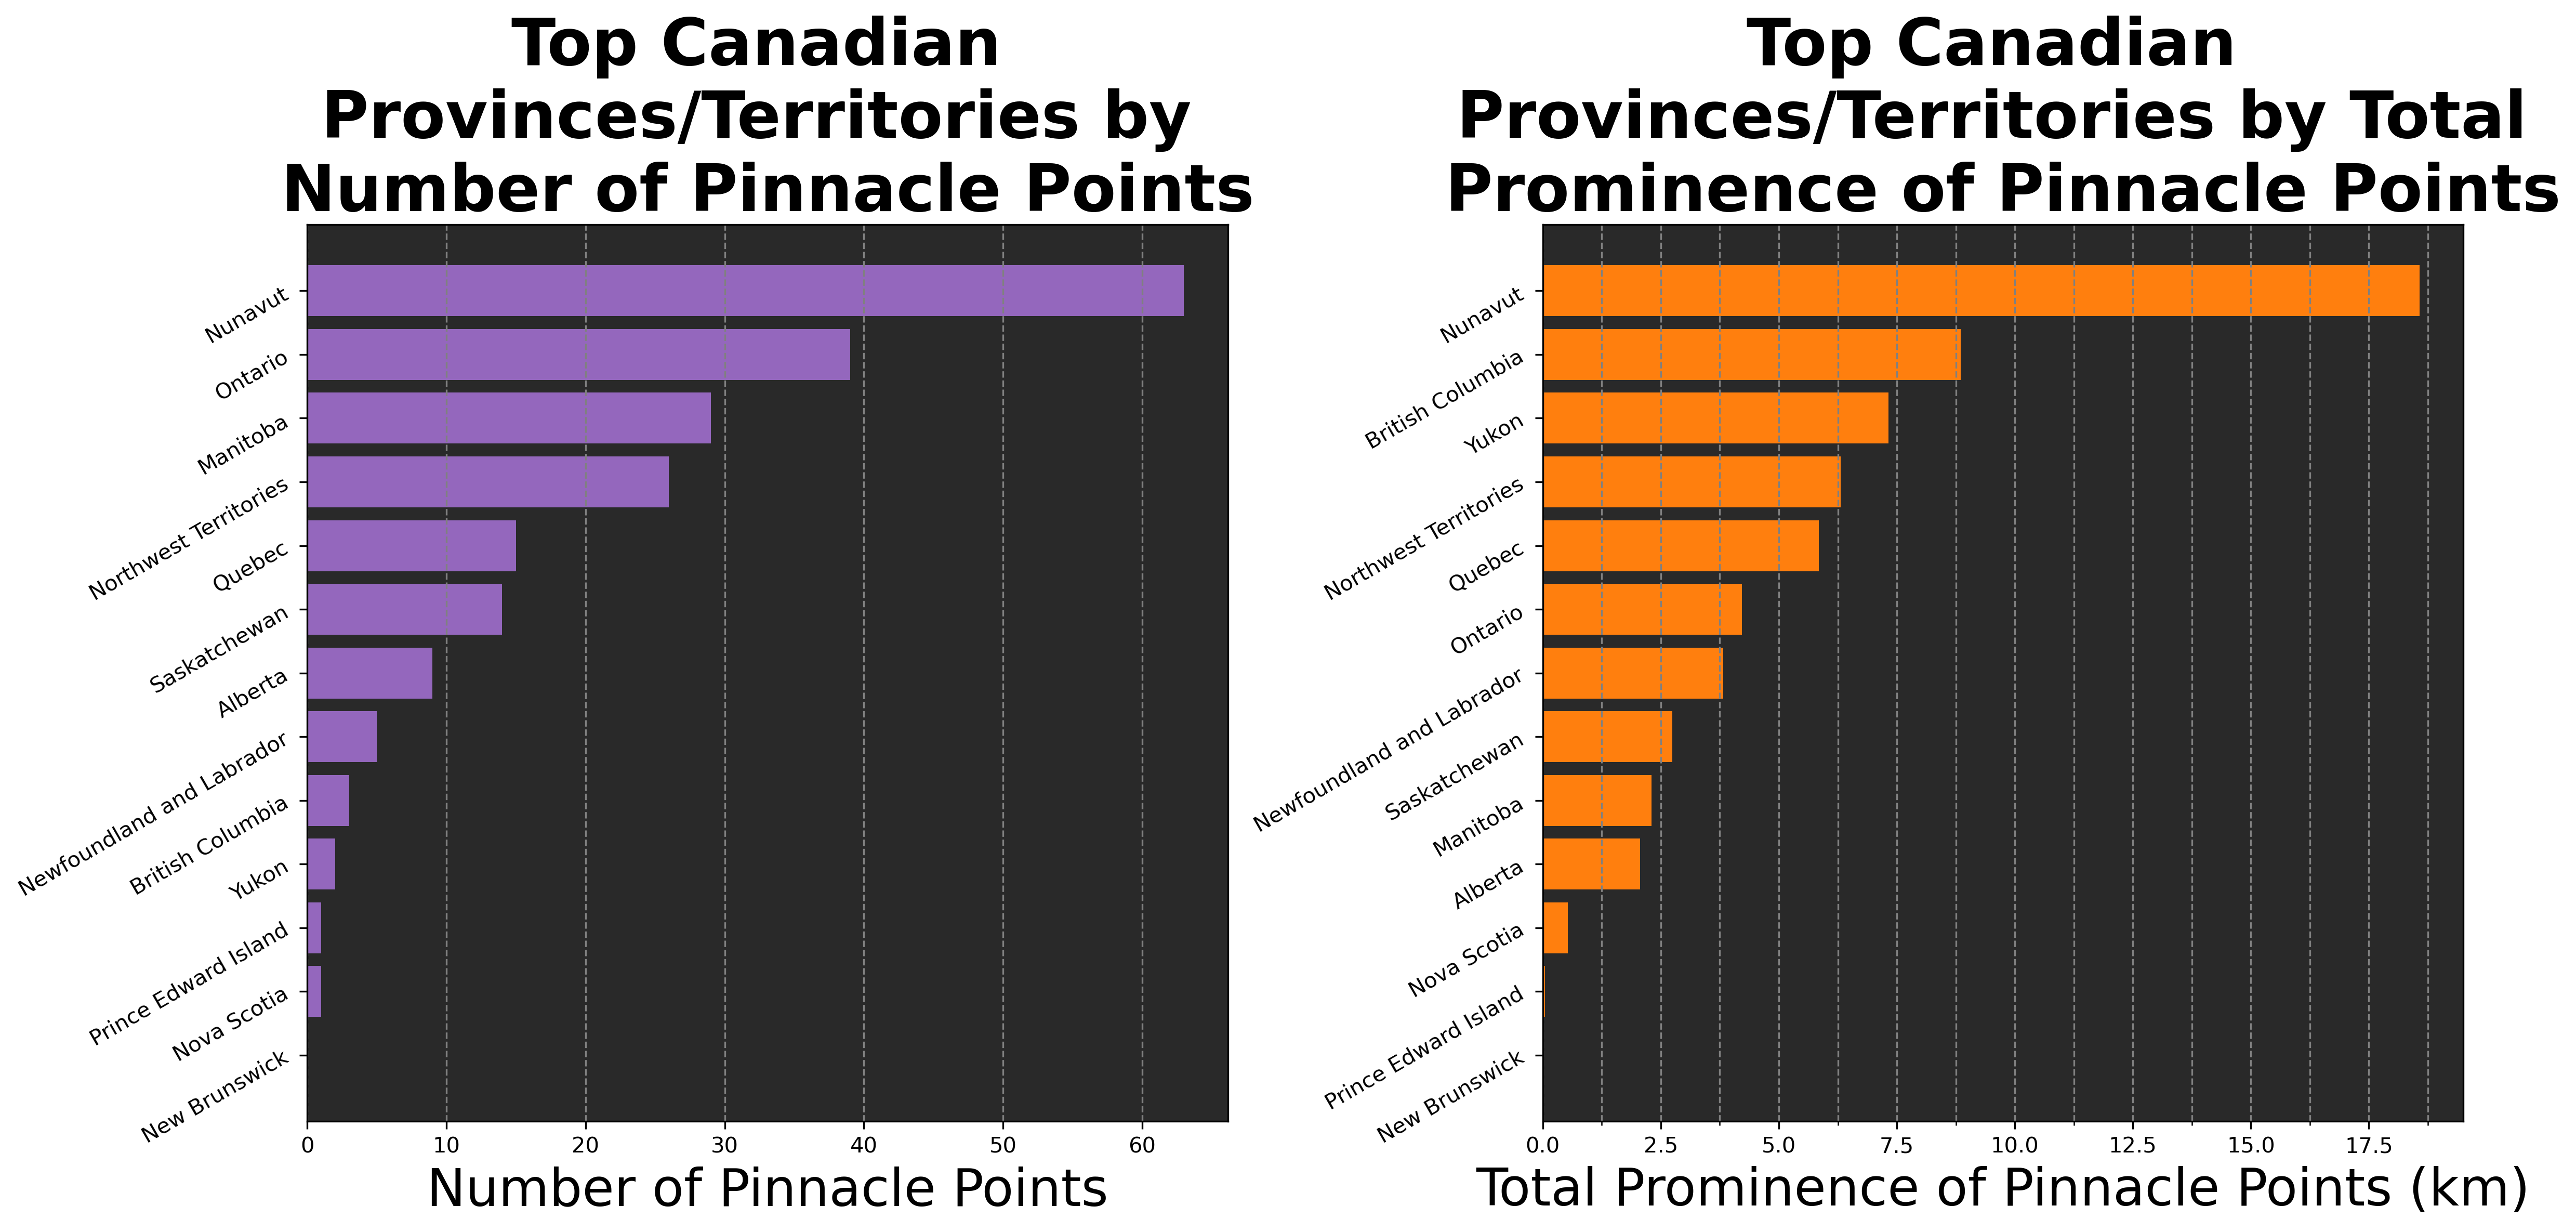

In [6]:
canadianProvinces = ['Ontario', 'Quebec', 'New Brunswick', 'Prince Edward Island', 'Nova Scotia', 
                     'Newfoundland and Labrador', 'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia',
                     'Yukon', 'Northwest Territories', 'Nunavut']

summitsByStateCanada = summitsByState.query('country == "Canada"').copy()
for province in canadianProvinces:
    if province not in np.array(summitsByStateCanada.index):
        dudProvince = {'number': 0, 'totalProminence_m': 0}
        summitsByStateCanada.loc[province] = dudProvince
        
compareTopGroups(summitsByStateCanada, 
                 'Top Canadian \nProvinces/Territories by \nNumber of Pinnacle Points', 
                 'Top Canadian \nProvinces/Territories by Total \nProminence of Pinnacle Points',
                 'pinnicalPoints_canadaStats.png')

In [63]:
earthRadius = 6371146 # in m

def horizonDistance(prm):
    return np.sqrt(2*earthRadius*prm)

def getHorizonColor(prominence):
    if prominence >= 3000:
        return 'red'
    elif prominence >= 300:
        return 'orange'
    else:
        return 'yellow'

def addCircleToMap(summit): 
    
    pinnaclePointRank = summits.prominence_m.rank(ascending=False)[summits.prominence_m == summit.prominence_m].iloc[0]
    
    toolTip = (f'Latitude: {round(summit.latitude, 4)}<br>Longitude: {round(summit.longitude, 4)}<br>' 
             + f'Prominence: {summit.prominence_m} m<br>Elevation: {summit.elevation_m} m<br>'
             + f'Horizon Distance: {round(horizonDistance(summit.prominence_m)/1000, 1)} km')
        
    folium.Circle(
        location = [summit.latitude, summit.longitude],
        radius = horizonDistance(summit.prominence_m),
        fill = True,
        fill_color = getHorizonColor(summit.prominence_m),
        fill_opacity = 0.33,
        weight = 0.3,
        color = 'black',
        tooltip = toolTip
    ).add_to(horizonMap)
    
    folium.RegularPolygonMarker(
        location = [summit.latitude, summit.longitude],
        number_of_sides=3,
        radius = 3,
        fill = True,
        fill_color = 'black',
        fill_opacity = 1,
        weight = 0,
        gradient = False,
        rotation = 30,
        tooltip = toolTip
    ).add_to(horizonMap)
    
horizonMap = folium.Map(location=[30, 0], zoom_start=2, tiles='Stamen Terrain')
summits300.apply(lambda summit: addCircleToMap(summit), axis=1)    

legend_html = """
    <div style="
        background-color: rgba(255, 255, 255, 0.9);
        padding: 5px;
        font-size: 12px;
        position: absolute;
        top: 10px;
        right: 10px;
        z-index: 1000;
    ">
        <div style="display: flex; align-items: center; cursor: pointer;" onclick="toggleLegend()">
            <div id="chevronIcon" style="margin-left: 11px; margin-right: 15px; width: 10px; height: 10px; 
                border-style: solid; border-width: 0 2px 2px 0; transform: rotate(45deg);"></div>
            <h4 style="margin: 0; margin-right: 50px;">Earth's Pinnacle Points</h4>
        </div>
        <div id="legendContent" style="display: none; margin-top: 5px;">
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 20px; margin-right: -2px; margin-top: 5px">
                        <svg width="6" height="6">
                            <polygon points="0,6 3,0 6,6" fill="black" />
                        </svg>
                    </div>
                    <div class="col" style="margin-top: 7px">
                        <div class="col">Pinnacle points [Count: 2779]</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 12px; margin-right: 6px; margin-top: 5px">
                        <svg width="22" height="22">
                            <circle cx="11" cy="11" r="10" fill="rgba(255, 255, 0, 0.33)" stroke="black" stroke-width="0.3" />
                        </svg>
                    </div>
                    <div class="col">Viewable area for pinnacle points with<br>30 m &le; prominence < 300 m [Count: 2170]</div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 12px; margin-right: 6px; margin-top: 5px">
                        <svg width="22" height="22">
                            <circle cx="11" cy="11" r="10" fill="rgba(255, 165, 0, 0.33)" stroke="black" stroke-width="0.3" />
                        </svg>
                    </div>
                    <div class="col">Viewable area for pinnacle points with<br>300 m &le; prominence < 3000 m [Count: 559]</div>
                </div>        
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 12px; margin-right: 6px; margin-top: 5px">
                        <svg width="22" height="22"">
                            <circle cx="11" cy="11" r="10" fill="rgba(255, 0, 0, 0.33)" stroke="black" stroke-width="0.3" />
                        </svg>
                    </div>
                    <div class="col">Viewable area for pinnacle points with<br>prominence &ge; 3000 m [Count: 50]</div>
                </div>
            </p>
        </div>
    </div>

    <script>
        function toggleInfoWindow() {
            var infoWindow = document.getElementById("infoWindow");
            var infoIcon = document.getElementById("informationIcon");

            if (infoWindow.style.display === "block") {
                infoWindow.style.display = "none";
                infoIcon.style.fill = "rgba(255, 255, 255, 0.9)";
            } else {
                infoWindow.style.display = "block";
                infoIcon.style.fill = "rgba(255, 255, 0, 0.9)";
            }
        }
    </script>

    <script>
        function toggleLegend() {
            var contentDiv = document.getElementById("legendContent");
            var chevronIcon = document.getElementById("chevronIcon");

            if (contentDiv.style.display === "block") {
                contentDiv.style.display = "none";
                chevronIcon.style.transform = "rotate(45deg)";
            } else {
                contentDiv.style.display = "block";
                chevronIcon.style.transform = "rotate(225deg)";
            }
        }
    </script>
"""

horizonMap.get_root().html.add_child(folium.Element(legend_html))

horizonMap.get_root().html.add_child(folium.Element('''
    <div id="infoIcon" style="position: absolute; bottom: 15px; right: 5px; cursor: pointer; z-index: 1001;">
        <svg id="informationIcon" width="30" height="30" viewBox="0 0 30 30" fill="white" stroke="black" stroke-width="2" 
            stroke-linecap="round" stroke-linejoin="round" onclick="toggleInfoWindow()">
            <circle cx="12" cy="12" r="10"></circle>
            <line x1="12" y1="16" x2="12" y2="12"></line>
            <line x1="12" y1="8" x2="12" y2="8"></line>
        </svg>
    </div>
    <div id="infoWindow" style="display: none; overflow-y: auto; position: absolute; top: 50%; left: 50%; 
        transform: translate(-50%, -50%); background-color: rgba(255, 255, 255, 0.9); padding: 10px; width: 500px; 
        height: 500px;  z-index: 1000;">
        <h3>Definitions</h3>
        <p>A <b>pinnacle point</b> is a point from which no higher point can be seen. More specifically, 
            a pinnacle point is a point with zero <b>inferiority</b>, where inferiority is defined as the maximum elevation 
            that can be seen in a direct line of sight from a point minus the point's elevation. 
            Since all points can see themselves, the minimum possible inferiority is zero.
        </p> 
        <h3>Finding Pinnacle Points</h3>
        <p>Thanks to Kai Xu for inspiring my search for pinnacle points with his own search for 
            <a href="https://ototwmountains.com/">on-top-of-the-world mountains</a>. Also, thanks to Andrew Kirmse 
            for his public list of <a href="https://www.andrewkirmse.com/prominence">7,798,709 summits</a> 
            with a prominence greater than 100 ft. I would not have been able to get this project off the 
            ground without it. Even with it, I have to make many approximations. Firstly, I assume the Earth to be a 
            sphere instead of an oblate spheroid. I do not take into account the effect of 
            atmospheric refraction as well.
        </p>
        <p>For all 7,798,709 summits, I find the summit's horizon distance defined as &radic;(2*R_earth*Prominence). 
            Prominence is used instead of elevation since prominence is a 
            better measure of a summit's rise above its surroundings. I then use an algorithm to find all 
            summits that have no higher summits in view. I define two summits to be in view if their 
            geospatial distance is less than the sum of their horizon distances. This is far from ideal. 
            Not only is the equation for horizon distance an approximation, the very concept of horizon 
            distance is flawed. Ultimately, viewshed analysis needs to be done to find Earth's pinnacle points 
            with greater confidence and accuracy. I am investigating how to best do this given the high computational cost of 
            viewshed analysis.
        </p>
        <p>Check out the latest algorithm on <a href="https://github.com/jgbreault/PinnaclePoints">my github</a>.
        </p>
    </div>
'''))

horizonMap

In [ ]:
horizonMap.save('index.html')

In [8]:
def findClosestPinnaclePoints(lat, lng, summits=summits, num=5):
    latRad, lngRad = np.radians(lat), np.radians(lng)

    deltaLat = np.radians(summits.latitude) - latRad
    deltaLng = np.radians(summits.longitude) - lngRad

    # Apply Haversine formula to calculate distances
    a = np.sin(deltaLat/2)**2 + np.cos(deltaLat)*np.cos(np.radians(summits.latitude))*np.sin(deltaLng/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distances = earthRadius/1000 * c
    
    distances = distances.sort_values().round(1)
    closestDistances = distances.head(num)
    closestPinnaclePoints = summits.loc[closestDistances.index]
    closestPinnaclePoints['distance_km'] = closestDistances
        
    return closestPinnaclePoints

findClosestPinnaclePoints(43.369325, -80.318285)

,country,state,latitude,longitude,elevation_m,prominence_m,distance_km
1166,Canada,Ontario,43.5275,-80.7239,435.9,41.1,42.2
937,Canada,Ontario,44.3700,-80.2614,541.9,283.2,111.4
1430,Canada,Ontario,43.8914,-81.4131,350.8,38.1,118.5
1995,Canada,Ontario,43.2419,-81.8372,212.4,32.6,144.8
1184,United States,Ohio,41.3997,-81.1039,425.5,99.1,231.7


A pinnacle point is a point from which no higher point can be seen. More specifically, a pinnacle point is a point with a zero inferiority, where inferiority is defined as the maximum elevation that can be seen in a direct line of sight from a point minus the point's elevation. Since all points can see themselves, the minimum possible inferiority is zero.

Thanks to Kai Xu for inspiring my search for pinnacle points with your own search for on-top-of-the-world mountains (https://ototwmountains.com/). And thanks to Andrew Kirmse for his public list of 7,798,709 summits with a prominence greater than 100 ft (https://www.andrewkirmse.com/prominence). I would not have been able to get this project off the ground without it. Even with it, I had to make many approximations. Firstly, I assume the Earth to be a sphere instead of the an oblate spheroid. I also do not take into account the effect of atmospheric refraction.

For all 7,798,709 summits, I find the summit's horizon distance defined as sqrt(2Rprm). Prominence is used to calculate horizon distance instead of elevation since prominence is a better measure of a summit's rise above its surroundings. I then use an algorithm to find all summits that have no higher summits in view. I define two summits to be in view if their geospatial distance is less than the sum of their horizon distances. This is far from ideal. Not only is the equation for horizon distance an approximation, the very concept of horizon distance is flawed. Ultimately, viewshed analysis should be done to find Earth's pinnacle points with in more confidence. I am investigating how to best do this given the high computational cost of viewshed analysis.